In [1]:
import numpy as np
import pandas as pd
from math import log, log2, inf

import sklearn.tree
import graphviz
import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re #regular expression library for manipulating text
import nltk

from collections import Counter
from sklearn.datasets import make_classification, load_digits
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.metrics import roc_curve, roc_auc_score, log_loss, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import minmax_scale, PolynomialFeatures
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
from nltk.stem.porter import PorterStemmer
from sklearn.tree import DecisionTreeClassifier
import sklearn.neighbors
from collections import OrderedDict

In [2]:
x_tr = pd.read_csv('data_reviews/x_train.csv')
y_tr = pd.read_csv('data_reviews/y_train.csv')

x_tr_text = x_tr['text'].values.tolist() #tr_text_list
y_tr_text = y_tr['is_positive_sentiment'].to_numpy()

documents = x_tr_text

In [3]:
good_list = pd.read_csv('positive-words.txt')
good_list2 = good_list['text'].values.tolist()
stop_words_list = pd.read_csv('stop-words.txt')
stop_words_list2 = stop_words_list['text'].values.tolist()
bad_list = pd.read_csv('bad-words.txt')
bad_list2 = bad_list['text'].values.tolist()

In [4]:
#Creating our own tokenizers
def simple_tokenizer(str_input):
    # Replace anything that is not a letter, number, or hyphen.
    # Remove the "\-" to see the effect.
    str_input = str_input.replace("'", "")
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()

    # We can also add in some other functionality; note that his will
    def prune_bad(w):
        for a in range(len(bad_list2)):
            if w == bad_list2[a]:
                w = 'bad'
        return w
    
    def prune_good(w):
        for b in range(len(good_list2)):
            if w == good_list2[b]:
                w = 'good'
        return w
    
    words = [prune_bad(word) for word in words]
    words = [prune_good(word) for word in words]  
    
    def numbers(w):
        if w.isnumeric():
            w = 'num'
        return w
    
    words = [numbers(word) for word in words]
    
    #new code
    res = []
    [res.append(x) for x in words if x not in res]
    
    return words

In [5]:
count_vectorizer = CountVectorizer(tokenizer=simple_tokenizer)
x = count_vectorizer.fit_transform(documents)
features = count_vectorizer.get_feature_names()
print("Number of features: ", len(features))

Number of features:  4145


In [6]:
#contains 400_000 vocabulary words with 50-value vector
word_embeddings = pd.read_csv('pretrained_word_embeddings/glove.6B.50d.txt.zip',
                               header=None, sep=' ', index_col=0,
                               nrows=100000, compression='zip', encoding='utf-8', quoting=3)
# Build a dict that will map from string word to 50-dim vector
word_list = word_embeddings.index.values.tolist()
word2vec = OrderedDict(zip(word_list, word_embeddings.values))

def word_embed_list(tr_text_list, feat_name, word2vec):
    x_word_ = list()
    for a in range(len(tr_text_list)):
        x_word = list()
        temp = tr_text_list[a].split(" ")
        for b in range(len(temp)):
            if temp[b] in feat_name:
                word = temp[b]
                x_word.append(word)
        x_word_.append(x_word)

    x_vect_2 = list()
    x_word_2 = list()
    for a in range(len(tr_text_list)):
        x_vect = list()
        x_word = list()
        temp = x_word_[a]
        for b in range(len(temp)):
            if temp[b] in word2vec:
                word = temp[b]
                vect = word2vec[word]
                x_word.append(word)
                x_vect.append(vect)
        x_vect_2.append(x_vect)
        x_word_2.append(x_word)

    x_vect_tot = list()
    for a in range(len(x_vect_2)): #for each review
        x_vect_sum = np.zeros(50)
        for b in range(len(x_vect_2[a])): #for each of the words in one review
            x_vect_sum += x_vect_2[a][b]
        if len(x_vect_2[a]) != 0:
            x_vect_sum = x_vect_sum/(len(x_vect_2[a]))
        x_vect_tot.append(x_vect_sum)
        
    return np.array(x_vect_tot)

# Logistic Regression

### Basic CountVectorizer with best_params GridSearchCV: Score and Leaderboard Score
best parameters = {'C': 1, 'max_iter': 10000, 'penalty': 'l2', 'random_state': 1, 'solver': 'liblinear'}

In [7]:
def CV_logistic(x,y, name='option name'):
    #cross validation & calculate the score >80%
    #Split up training data to give yourself some y_test data

    print(f"-----------------\nClassify with {name}, 5 folds\n-----------------")
    #kfold basically just splits the data automatically and gives better data confidence
    k = 5
    kfold = KFold(n_splits=k, shuffle = True, random_state = 5)
    train_scores = []
    test_scores = []

    #build and evaluate model for each value C
    score_list_tr = list()
    score_list_te = list()        
    model = LogisticRegression(solver='liblinear', random_state=1, max_iter=10_000, penalty='l2')
    for train_idx, test_idx in kfold.split(x):
        X_train, X_test = x[train_idx,:], x[test_idx,:],
        y_train, y_test = y[train_idx], y[test_idx]
        #TRAINING: fit and predict
        model.fit(X_train, y_train)
        y_prob_tr = model.predict_proba(X_train)
        score_tr = model.score(X_train, y_train) 
        score_list_tr.append(score_tr)
        #test stuff now
        y_prob_te = model.predict_proba(X_test)
        score_te = model.score(X_test, y_test)
        score_list_te.append(score_te)

    return np.average(score_list_tr), np.average(score_list_te)


In [8]:
vectorizer = TfidfVectorizer()
x_logistic = vectorizer.fit_transform(documents)

feat_name = vectorizer.get_feature_names()
x_vect_tot = word_embed_list(x_tr_text, feat_name, word2vec)

score_tr_log1, score_te_log1 = CV_logistic(x_vect_tot, y_tr_text, name='Logistic Regression')

print("\nAverage accuracy train: ", score_tr_log1)
print("Average accuracy test: ", score_te_log1)

-----------------
Classify with Logistic Regression, 5 folds
-----------------

Average accuracy train:  0.7002083333333334
Average accuracy test:  0.68625


### Best CountVectorizer with best_params_ GridSearchCV: Score and Leaderboard Score

In [9]:
vectorizer_b = TfidfVectorizer(stop_words = stop_words_list2, tokenizer=simple_tokenizer) #take apostrophe's out here
x_logistic = vectorizer_b.fit_transform(documents)

feat_name = vectorizer_b.get_feature_names()
x_vect_tot = word_embed_list(x_tr_text, feat_name, word2vec)

score_tr_log2, score_te_log2 = CV_logistic(x_vect_tot, y_tr_text, name='Logistic Regression')

print("\nAverage accuracy train: ", score_tr_log2)
print("Average accuracy test: ", score_te_log2)

C:\Users\hdohe\miniconda3\envs\ml135_env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bad', 'good'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


-----------------
Classify with Logistic Regression, 5 folds
-----------------

Average accuracy train:  0.6443749999999999
Average accuracy test:  0.6166666666666666


# Neural Net (MLP)

### Basic CountVectorizer with best_params GridSearchCV
Best parameters: {'activation': 'logistic', 'alpha': 0.001, 'max_iter': 10000, 'solver': 'sgd'}

In [10]:
def CV_NN(x,y, name='option name'):
    #cross validation & calculate the score >80%
    #Split up training data to give yourself some y_test data

    print(f"-----------------\nClassify with {name}, 5 folds\n-----------------")
    #kfold basically just splits the data automatically and gives better data confidence
    k = 5
    kfold = KFold(n_splits=k, shuffle = True, random_state = 5)
    train_scores = []
    test_scores = []

    #build and evaluate model for each value C
    score_list_tr = list()
    score_list_te = list()        
    model = MLPClassifier(alpha=0.1, activation='relu', solver='sgd', max_iter=10_000, random_state=1)
    for train_idx, test_idx in kfold.split(x):
        X_train, X_test = x[train_idx,:], x[test_idx,:],
        y_train, y_test = y[train_idx], y[test_idx]
        #TRAINING: fit and predict
        model.fit(X_train, y_train)
        y_prob_tr = model.predict_proba(X_train)
        score_tr = model.score(X_train, y_train) 
        score_list_tr.append(score_tr)
        #test stuff now
        y_prob_te = model.predict_proba(X_test)
        score_te = model.score(X_test, y_test)
        score_list_te.append(score_te)

    return np.average(score_list_tr), np.average(score_list_te)

In [11]:
vectorizer = TfidfVectorizer()
x_MLP = vectorizer.fit_transform(documents)

feat_name = vectorizer.get_feature_names()
x_vect_tot = word_embed_list(x_tr_text, feat_name, word2vec)

score_tr_mlp1, score_te_mlp1 = CV_NN(x_vect_tot, y_tr_text, name='Neural Net: MLP')

print("\nAverage accuracy train: ", score_tr_mlp1)
print("Average accuracy test: ", score_te_mlp1)

-----------------
Classify with Neural Net: MLP, 5 folds
-----------------

Average accuracy train:  0.6991666666666667
Average accuracy test:  0.6879166666666666


In [12]:
#export to leaderboard
tr_text_list_y = y_tr['is_positive_sentiment'].to_numpy()
x_test_df = pd.read_csv('data_reviews/x_test.csv')
te_text_list = x_test_df['text'].values.tolist()

#vectorizer TEST data
vectorizer_test = TfidfVectorizer()
#fit transformed to x training text data (used to be X_Option1)
fitTransform_xTrain = vectorizer_test.fit_transform(documents) 
feat_name = vectorizer_test.get_feature_names()


#the new x training numerical data instead of X_option1 (used to be x_vect_tot)
wordEmbed_xTrain = word_embed_list(documents, feat_name, word2vec) #different because not using documents

#fit logistic regression model
model = MLPClassifier(alpha=0.1, activation='relu', solver='sgd', max_iter=10_000, random_state=1)
#fit to vectorized x training text data and their y values
model.fit(wordEmbed_xTrain, tr_text_list_y) 

#transform and vectorize test text (used to be X_final_test)
transform_testText = vectorizer_test.transform(te_text_list) #this is different frrom first transform


#new x test data instead of X_final_test (used to be x_vect_tot_test)
wordEmbed_xTest = word_embed_list(te_text_list, feat_name, word2vec)
#print(wordEmbed_xTest.shape)

#export to leaderboard
yproba1_test = model.predict_proba(wordEmbed_xTest)[:,1]
np.savetxt('yproba1_test.txt', yproba1_test)

### Best CountVectorizer with best_params_ GridSearchCV: Score and Leaderboard Score

In [13]:
vectorizer_b = TfidfVectorizer(stop_words = stop_words_list2, tokenizer=simple_tokenizer)
x_MLP_b = vectorizer_b.fit_transform(documents)

feat_name = vectorizer_b.get_feature_names()
x_vect_tot = word_embed_list(x_tr_text, feat_name, word2vec)

score_tr_mlp2, score_te_mlp2 = CV_NN(x_vect_tot, y_tr_text, name='Neural Net: MLP')

print("\nAverage accuracy train: ", score_tr_mlp2)
print("Average accuracy test: ", score_te_mlp2)

C:\Users\hdohe\miniconda3\envs\ml135_env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bad', 'good'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


-----------------
Classify with Neural Net: MLP, 5 folds
-----------------

Average accuracy train:  0.6584375
Average accuracy test:  0.6295833333333334


# Decision Tree

### Basic CountVectorizer with best_params GridSearchCV

In [14]:
def CV_DT(x,y, name='option name'):
    #cross validation & calculate the score >80%
    #Split up training data to give yourself some y_test data

    print(f"-----------------\nClassify with {name}, 5 folds\n-----------------")
    #kfold basically just splits the data automatically and gives better data confidence
    k = 5
    kfold = KFold(n_splits=k, shuffle = True, random_state = 5)
    train_scores = []
    test_scores = []

    #build and evaluate model for each value C
    score_list_tr = list()
    score_list_te = list()        
    model = DecisionTreeClassifier(random_state=1, min_samples_split=10)
    for train_idx, test_idx in kfold.split(x):
        X_train, X_test = x[train_idx,:], x[test_idx,:],
        y_train, y_test = y[train_idx], y[test_idx]
        #TRAINING: fit and predict
        model.fit(X_train, y_train)
        y_prob_tr = model.predict_proba(X_train)
        score_tr = model.score(X_train, y_train) 
        score_list_tr.append(score_tr)
        #test stuff now
        y_prob_te = model.predict_proba(X_test)
        score_te = model.score(X_test, y_test)
        score_list_te.append(score_te)

    return np.average(score_list_tr), np.average(score_list_te)

In [15]:
vectorizer = TfidfVectorizer()
x_DT = vectorizer.fit_transform(documents)

feat_name = vectorizer.get_feature_names()
x_vect_tot = word_embed_list(x_tr_text, feat_name, word2vec)

score_tr_DT1, score_te_DT1 = CV_DT(x_vect_tot, y_tr_text, name='Decision Tree')

print("\nAverage accuracy train: ", score_tr_DT1)
print("Average accuracy test: ", score_te_DT1)

-----------------
Classify with Decision Tree, 5 folds
-----------------

Average accuracy train:  0.9176041666666667
Average accuracy test:  0.5845833333333335


### Best CountVectorizer with best_params_ GridSearchCV: Score and Leaderboard Score

In [16]:
vectorizer_b = TfidfVectorizer(stop_words = stop_words_list2, tokenizer=simple_tokenizer)
x_DT_b = vectorizer_b.fit_transform(documents)

feat_name = vectorizer_b.get_feature_names()
x_vect_tot = word_embed_list(x_tr_text, feat_name, word2vec)

score_tr_DT2, score_te_DT2 = CV_DT(x_vect_tot, y_tr_text, name='Decision Tree')

print("\nAverage accuracy train: ", score_tr_DT2)
print("Average accuracy test: ", score_te_DT2)

C:\Users\hdohe\miniconda3\envs\ml135_env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bad', 'good'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


-----------------
Classify with Decision Tree, 5 folds
-----------------

Average accuracy train:  0.85375
Average accuracy test:  0.56125


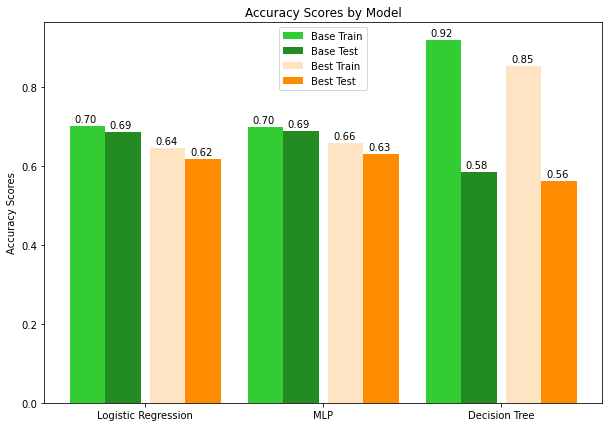

In [17]:
N = 3
train_score_base = (score_tr_log1, score_tr_mlp1, score_tr_DT1)
test_score_base = (score_te_log1, score_te_mlp1, score_te_DT1)
train_score_best = (score_tr_log2, score_tr_mlp2, score_tr_DT2)
test_score_best = (score_te_log2, score_te_mlp2, score_te_DT2)

plt.subplots(figsize=(10, 7))
ind = np.arange(N) 
width = 0.2

plt.bar(ind, train_score_base, width, label='Base Train', color = 'limegreen')
plt.bar(ind + width, test_score_base, width, label='Base Test', color = 'forestgreen')
plt.bar(ind + width + width + .05, train_score_best, width, label='Best Train', color = 'bisque')
plt.bar(ind + width + width + width + .05, test_score_best, width, label='Best Test', color = 'darkorange')

plt.ylabel('Accuracy Scores')
plt.title('Accuracy Scores by Model')

plt.xticks(ind + 0.025 + (3*width) / 2, ('Logistic Regression' , 'MLP', 'Decision Tree'))
plt.legend(loc=9)

for index,data in enumerate(train_score_base):
    plt.text(x=index-.075 , y =data+.01 , s='%.2f' % data , fontdict=dict(fontsize=10))

for index,data in enumerate(test_score_base):
    plt.text(x=index+0.2-.075 , y =data+.01 , s='%.2f' % data , fontdict=dict(fontsize=10))

for index,data in enumerate(train_score_best):
    plt.text(x=index+0.4+.05-.07 , y =data+.01 , s='%.2f' % data , fontdict=dict(fontsize=10))

for index,data in enumerate(test_score_best):
    plt.text(x=index+0.6+.05-.07 , y =data+.01 , s='%.2f' % data , fontdict=dict(fontsize=10))

plt.show()


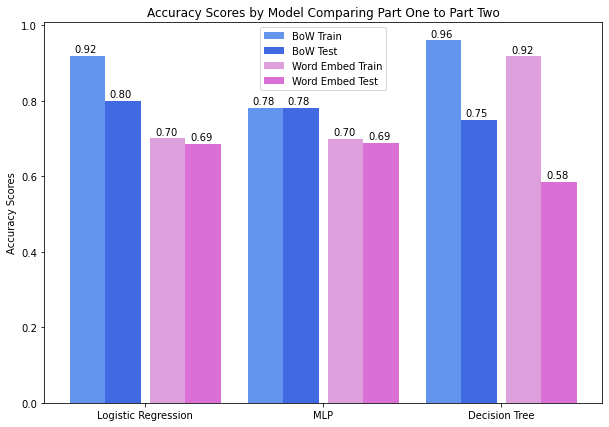

In [18]:
N = 3
train_score_bow = (0.92, 0.78, 0.96)
test_score_bow = (0.80, 0.78, 0.75)
train_score = (score_tr_log1, score_tr_mlp1, score_tr_DT1)
test_score = (score_te_log1, score_te_mlp1, score_te_DT1)
plt.subplots(figsize=(10, 7))
ind = np.arange(N) 
width = 0.2
plt.bar(ind, train_score_bow, width, label='BoW Train', color='cornflowerblue')
plt.bar(ind + width, test_score_bow, width, label='BoW Test', color='royalblue')
plt.bar(ind + width + width + 0.05, train_score, width, label='Word Embed Train', color='plum')
plt.bar(ind + width + width + width + 0.05, test_score, width, label='Word Embed Test', color='orchid')

plt.ylabel('Accuracy Scores')
plt.title('Accuracy Scores by Model Comparing Part One to Part Two')

plt.xticks(ind + 0.025 + (3*width) / 2, ('Logistic Regression' , 'MLP', 'Decision Tree'))
plt.legend(loc=9)

for index,data in enumerate(train_score_bow):
    plt.text(x=index-.075 , y =data+.01 , s='%.2f' % data , fontdict=dict(fontsize=10))

for index,data in enumerate(test_score_bow):
    plt.text(x=index+0.2-.075 , y =data+.01 , s='%.2f' % data , fontdict=dict(fontsize=10))

for index,data in enumerate(train_score):
    plt.text(x=index+0.4+.05-.07 , y =data+.01 , s='%.2f' % data , fontdict=dict(fontsize=10))

for index,data in enumerate(test_score):
    plt.text(x=index+0.6+.05-.07 , y =data+.01 , s='%.2f' % data , fontdict=dict(fontsize=10))

plt.show()